In [132]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to foods, columns to nutrients.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='highs')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

In [133]:
apikey = "ngZTL3EoRoYFex00m5L4bdOdbtctFiuu7MT4cTeM"

In [134]:
import fooddatacentral as fdc
import pandas as pd
from eep153_tools.sheets import read_sheets
import warnings

In [135]:
SHEETs = [("https://docs.google.com/spreadsheets/d/1CBbHwj62DyYoIubexC1uNchOYTM_qtdTCIVG-jco72s/edit#gid=75959120","Keto Food Prices"),]

In [136]:
df = read_sheets(SHEETs[0][0])[SHEETs[0][1]]
df

Key available for students@eep153.iam.gserviceaccount.com.


,Food,Quantity,Units,Price,Date,Location,FDC
0,salmon,7.00,oz,8.99,2/20/24,Safeway,175167
1,tuna,5.00,oz,1.29,2/20/24,Safeway,175156
2,chicken,1.25,pound,4.99,2/20/24,Safeway,2646171
3,cottage cheese,16.00,oz,2.99,2/20/24,Safeway,2346384
4,greek yogurt,32.00,oz,6.99,2/20/24,Safeway,2259794
5,spinach,8.00,oz,2.49,2/20/24,Safeway,1999632
6,carrots,1.00,pound,1.49,2/20/24,Safeway,2258586
7,kale,10.00,oz,3.99,2/20/24,Safeway,323505
8,collard greens,1.00,pound,3.49,2/20/24,trader joes,170406
9,coconut milk,13.50,floz,2.29,2/20/24,Safeway,170173


In [137]:
D = {}
count = 0
for food in  df.Food.tolist():
    try:
        FDC = df.loc[df.Food==food,:].FDC[count]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

FoodNutrients = pd.DataFrame(D,dtype=float)

In [138]:
# Convert food quantities to FDC units
df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
df['FDC Price'] = df['Price']/df['FDC Quantity']

df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Prices = df.groupby('Food',sort=False)['FDC Price'].min()

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



In [139]:
from eep153_tools.sheets import read_sheets

DRI_url = "https://docs.google.com/spreadsheets/d/1M1l9Md7X4Amaiecz0SBRsve-skrV_rD7O7ylWOeVpOw"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['diet_minimums'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['diet_maximums'].set_index('Nutrition')

Key available for students@eep153.iam.gserviceaccount.com.


/srv/conda/lib/python3.9/site-packages/eep153_tools/sheets.py:150: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [140]:
group = 'M 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,Prices,
                                  diet_min[group],diet_max[group],max_weight=12,tol=tol)

print("Cost of diet for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet for M 19-30 is $10.43 per day.


Diet (in 100s of grams or milliliters):
tuna              1.098929
kale              1.350046
collard greens    2.447604
almond milk       2.038541
mayonnaise        0.681639
hemp seeds        0.676079
black beans       3.707161
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          4525.184729     2400.000000
Fiber, total dietary              33.600000       33.600000
Folate, DFE                      400.000000      400.000000
Calcium, Ca                     2023.859964     1000.000000
Iron, Fe                          30.266160        8.000000
Magnesium, Mg                   1305.637119      400.000000
Niacin                            26.740352       16.000000
Phosphorus, P                   3486.009357      700.000000
Potassium, K                    8068.724767     4700.00

/srv/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1598: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



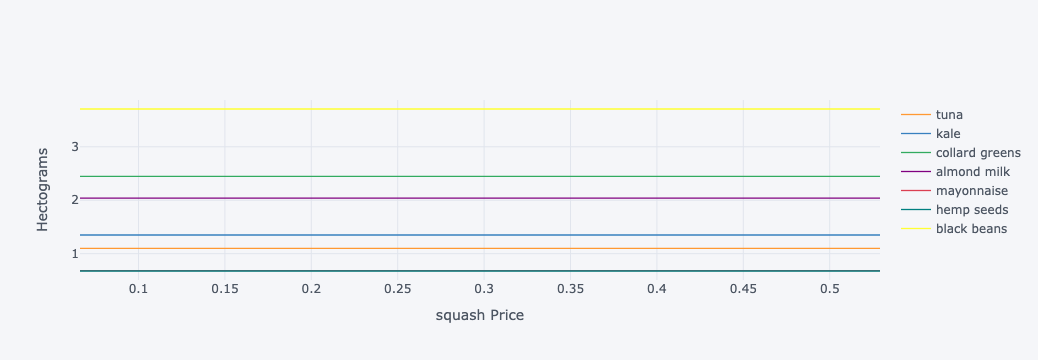

In [141]:
import cufflinks as cf
cf.go_offline()

ReferenceGood = 'squash'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,
                                  diet_min[group],diet_max[group],max_weight=12,tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(FoodNutrients,my_p,
                                       diet_min[group],diet_max[group],max_weight=12,tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')

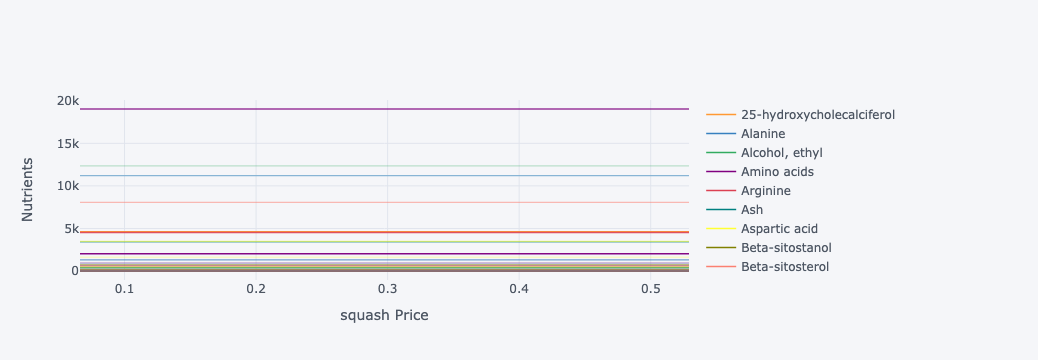

In [146]:
# Matrix product maps quantities of food into quantities of nutrients
FoodNutrients = FoodNutrients.drop(columns = 'egg')
FoodNutrients = FoodNutrients.fillna(0)
NutrientResponse = Diet_response@FoodNutrients.T

# Drop columns of missing nutrients
NutrientResponse = NutrientResponse.loc[:,NutrientResponse.count()>0]
NutrientResponse.iplot(xTitle='%s Price' % ReferenceGood,yTitle='Nutrients')

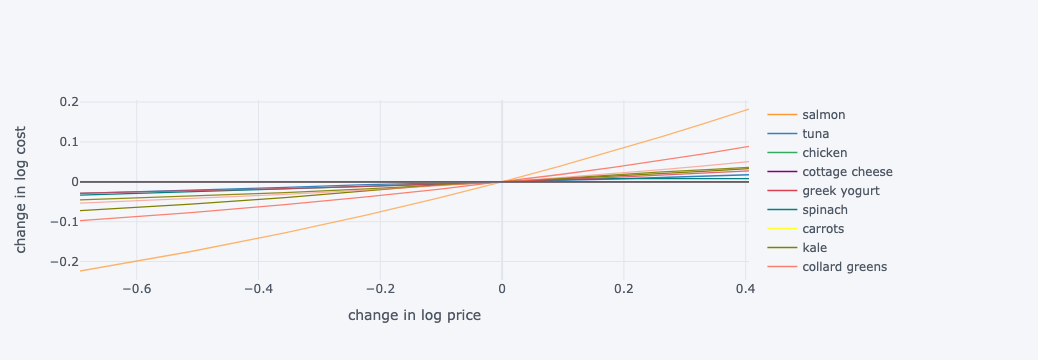

In [147]:
cf.go_offline()

scale = [.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol).fun

Price_response={}
for s in scale:
    cost = {}
    for i,p in enumerate(Prices):
        my_p = Prices.copy()
        my_p.iloc[i] = p*s
        result = solve_subsistence_problem(FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
        cost[Prices.index[i]] = np.log(result.fun/cost0)
    Price_response[np.log(s)] = cost

Price_response = pd.DataFrame(Price_response).T
Price_response.iplot(xTitle='change in log price',yTitle='change in log cost')